In [7]:
import cobra
import optslope
from optslope import calculate_slope_multi, filter_redundant_knockouts
import pandas as pd
from cobra.io import read_sbml_model
from cobra.flux_analysis import phenotype_phase_plane
from typing import Iterable
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Latex

plt.rcParams['font.family'] = "arial"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

#define the maximal number of knockouts that is allowed for the solutions
max_kos = 5

#define the carbon sources
carbon_sources = (
    ["methanol"],
    ["6pgc","methanol"],
    ["glc__D","methanol"],
    ["r5p","methanol"],
    ["xu5p__D","methanol"],
    ["dhap","methanol"],
    ["2pg","methanol"],
    ["ac","methanol"],
    ["pyr","methanol"],
    ["succ","methanol"],
    ["glu__L","methanol"],
    ["fru","methanol"]
    )

In [14]:
def replace_carbon_source_names(df):
    df.rename(columns = {
        "xu5p__D + methanol" : "xylose",
        "pyr + methanol" : "pyruvate",
        "succ + methanol" : "succinate",
        "ac + methanol" : "acetate",
        "2pg + methanol" : "glycerate",
        "glc__D + methanol" : "glucose",
        "6pgc + methanol" : "gluconate",
        "r5p + methanol" : "ribose",
        "glu__L + methanol" : "glutamate",
        "fru + methanol" : "fructose",
        "dhap + methanol" : "glycerol"},
        inplace = True)
    
    df = df[[
        "methanol",
        "fructose",
        "glucose",
        "ribose",
        "xylose",
        "gluconate",
        "acetate",
        "glutamate",
        "glycerate",
        "glycerol",
        "pyruvate",
        "succinate",
        ]]
    
    return df

def rename_gene_names(df):
    #df.rename(index = {
        #"FBA" : "$\Delta \it{fbaAB}$",
        #"FBP" : "$\Delta \it{fbp}$",
        #"TPI" : "$\Delta \it{tpiA}$",
        #"GAPD" : "$\Delta \it{gapA}$",
        #"PGK" : "$\Delta \it{pgk}$",
        #"ENO" : "$\Delta \it{eno}$",
        #"PGM" : "$\Delta \it{gpmAM}$",
        #"GLUDy" : "$\Delta \it{gdhA}$",
        #"FUM" : "$\Delta \it{fumABC}$",
        #"ICL" : "$\Delta \it{aceA}$",
        #"MALS" : "$\Delta \it{aceB}$",
        #"SUCDi" : "$\Delta \it{sucA}$"},
        #inplace = True)
    
    return df

def plot_heatmap(df, number_of_knockouts_min, number_of_knockouts_max, vmin, vmax, cbar_kws, cmap, carbon_sources):
    if number_of_knockouts_max > 1.0:
        df_1 = df.loc[df["no_knockouts"] == number_of_knockouts_min]
        df_2 = df.loc[df["no_knockouts"] == number_of_knockouts_max]
        df = pd.concat([df_1, df_2])
    else:
        df = df.loc[df["no_knockouts"] == 1.0]
    df = df.drop(columns = ["no_knockouts"])
    
    print("You get " + str(len(df)) + " solutions for max " + str(number_of_knockouts_max) +" knockouts")
        
    df = replace_carbon_source_names(df)
    df = rename_gene_names(df)
          
    plt.figure()
    
    fig = sns.heatmap(
        df,
        vmin,
        vmax,
        cmap,
        square = True,
        yticklabels = True,
        linewidths = 0.01,
        linecolor = "black",
        cbar_kws = cbar_kws)

    bottom, top = fig.get_ylim()
    fig.set_ylabel(ylabel = "")
    fig.set_yticklabels(fig.get_yticklabels(), fontsize=10.0)
    fig.set_xticklabels(fig.get_xticklabels(), fontsize=10.0)
        
    return fig

In [3]:
bio_df = pd.read_excel("dependent_strains_biomass_fraction_filtered5_kos.xlsx", index_col="knockouts")
r5p_df = pd.read_excel("dependent_strains_R5P_fraction_filtered5_kos.xlsx", index_col="knockouts")
r5p_bio_ratio_df = pd.read_excel("dependent_strains_R5P_to_biomass_fraction_ratio5_kos.xlsx", index_col="knockouts")

You get 12 solutions for max 1 knockouts


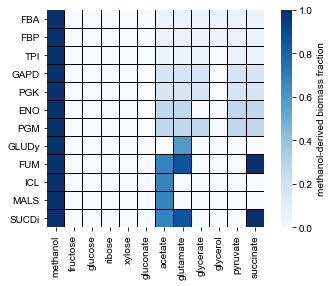

In [15]:
#-----> Plot heatmap for solutions with a certain number of knockouts and value them according to the methanol biomass fraction
#define the variables of the plot
number_of_knockouts_min = 1
number_of_knockouts_max = 1
vmin = 0
vmax = 1
cbar_kws = {"label":"methanol-derived biomass fraction"}
cmap = "Blues"

#create the plot and save it as vector graphic
methanol_biomass_fraction = plot_heatmap(bio_df, number_of_knockouts_min, number_of_knockouts_max, vmin, vmax, cbar_kws, cmap, carbon_sources)
methanol_biomass_fraction.figure.savefig("bio_1_knockout.pdf", bbox_inches="tight")

You get 12 solutions for max 1 knockouts


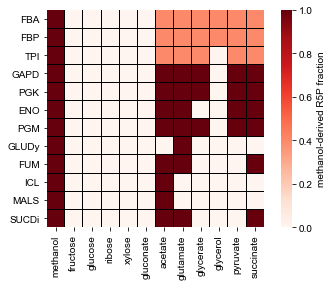

In [16]:
#-----> Plot heatmap for solutions with a certain number of knockouts and value them according to the RuMP biomass fraction

#define the variables of the plot
number_of_knockouts_min = 1
number_of_knockouts_max = 1
vmin = 0
vmax = 1

cbar_kws = {"label":"methanol-derived R5P fraction"}
cmap = "Reds"

#create the plot and save it as vector graphic
methanol_rump_fraction = plot_heatmap(r5p_df, number_of_knockouts_min, number_of_knockouts_max, vmin, vmax, cbar_kws, cmap, carbon_sources)
methanol_rump_fraction.figure.savefig("r5p_1_knockout.pdf", bbox_inches="tight")

You get 12 solutions for max 1 knockouts


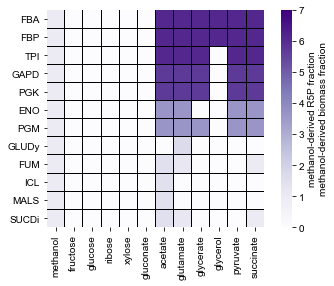

In [19]:
#-Plot--------------------------------------------------------------------------------------------------------------------
#define the variables of the plot
number_of_knockouts_min = 1
number_of_knockouts_max = 1
vmin = 0
vmax = 7.0
cbar_kws = {"label":"methanol-derived R5P fraction\nmethanol-derived biomass fraction",
           "ticks":[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]}
cmap = "Purples"

#plot and save figure
fig = plot_heatmap(r5p_bio_ratio_df, number_of_knockouts_min, number_of_knockouts_max, vmin, vmax, cbar_kws, cmap, carbon_sources)

fig.figure.savefig("r5p_bio_ratio_1_knockout.pdf", bbox_inches="tight")